In [15]:
from setup import generate_experiment
import matplotlib.pyplot as plt

# Tutorial 1: Generate list of experiments 

In [16]:
# Number of qubits (N)
N=3

# List of wanted elements indexes in the density matrix
wanted_index=[(0,3),(2,0)] 



Wanted Indexes [(0, 3), (2, 0)] corresponds to these Selective Blocks: [3, 2]

********************
Selective Block 3

Wanted Elements [(0, 3)]

Selective elements in block [(0, 3), (1, 2), (2, 1), (3, 0), (4, 7), (5, 6), (6, 5), (7, 4)]

Pauli Observables:
  Even-Y set (E): ['IXX', 'IYY', 'ZXX', 'ZYY']
  Odd-Y set  (O): ['IXY', 'IYX', 'ZXY', 'ZYX']

SEEQST circuit text:
  Circuit 1: (CNOT:1,2)(RY90:1)
  Circuit 2: (CNOT:1,2)(RX90:1)

Non-entangling cirucits:
['(RY90:1)(RY90:2)', '(RY90:1)(RX90:2)', '(RX90:1)(RY90:2)', '(RX90:1)(RX90:2)']
********************
Selective Block 2

Wanted Elements [(2, 0)]

Selective elements in block [(0, 2), (1, 3), (2, 0), (3, 1), (4, 6), (5, 7), (6, 4), (7, 5)]

Pauli Observables:
  Even-Y set (E): ['IXI', 'IXZ', 'ZXI', 'ZXZ']
  Odd-Y set  (O): ['IYI', 'IYZ', 'ZYI', 'ZYZ']

SEEQST circuit text:
  Circuit 1: (RY90:1)
  Circuit 2: (RX90:1)

Non-entangling cirucits:
['(RY90:1)', '(RX90:1)']


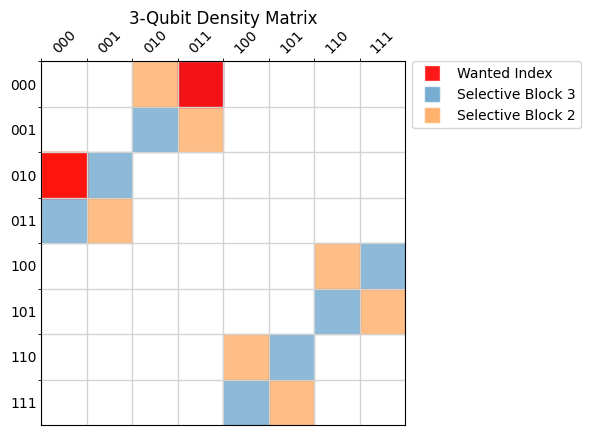

In [17]:
# Printing options , set True to print 
options={"density matrix plot":True, "wanted elements":True ,"selective elements":True,'circuits text':True,'non entangling circuits text':True,'observable':True}

#1. Identify selective blocks to wanted elements.
#2. Experiment list of circuits in text, qiskit  ( sel_circ_text,sel_circ_qiskit)
#3. Experiment list of circuits (not requiring entangling gates) in text, qiskit  (sel_circ_text_non_entangle,non_e_circ_qiskit)

selective_blocks, sel_circ_text, sel_circ_text_non_entangle, sel_circ_qiskit, non_e_circ_qiskit =generate_experiment(wanted_index,N,options)

# Avoid default ciruit implementation (design yourself for your own system connectivity)

Selective Block:  3
Circuit 1: 


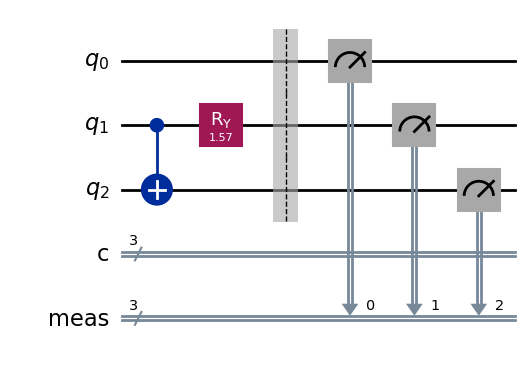

Circuit 2: 


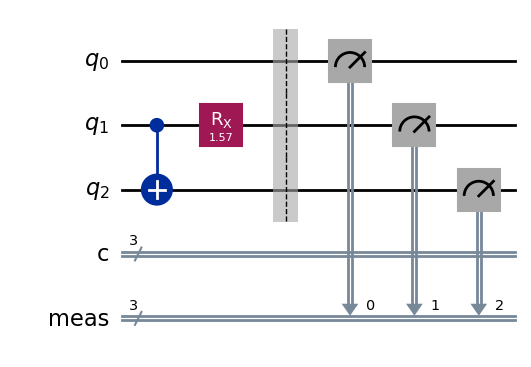

In [18]:
# Plot SEEQST Circuits 

for i, block in enumerate(selective_blocks[:1]):  # Printing Circuit for 1st Block
    print("Selective Block: ",block)
    print("Circuit 1: ")
    display(sel_circ_qiskit[i][0].draw('mpl'))
    print("Circuit 2: ")
    display(sel_circ_qiskit[i][1].draw('mpl')) 
